In [1]:
import pandas as pd
import fitter
import scipy.stats as stats
import matplotlib.pyplot as plt
import dill
import numpy as np

In [2]:
def get_hauptsprache_kanton(year:str):
    df_hauptspr = pd.read_excel("variable_hauptsprache_pro_kanton/rohdaten/je-d-01.08.01.02.xlsx", sheet_name=year)

    df_hauptspr = df_hauptspr.iloc[4:35, [0,2,4,6,8,10,12,14,16,18,20,22]].replace("X", -1)

    added = df_hauptspr.iloc[:,4:].sum(axis=1)

    df_hauptspr = df_hauptspr.drop(columns=df_hauptspr.columns[4:])

    df_hauptspr["andere"] = added

    df_hauptspr.set_index(df_hauptspr.columns[0], drop=True, inplace=True)

    df_hauptspr.columns = ["Deutsch", "Französisch", "Italienisch", "Andere"]

    df_hauptspr = df_hauptspr.transpose().astype("float").astype("Float64").replace(-1, pd.NA)

    return df_hauptspr

def get_geburtenrate_kanton():
    df_gebRate = pd.read_excel("variable_lebendgeburten_pro_jahr/rohdaten/su-d-01.04.01.01.08.xlsx", sheet_name="Total")

    df_gebRate.set_index(df_gebRate.columns[0], drop=True, inplace=True)

    df_gebRate.columns = df_gebRate.iloc[1,:].values.astype("int").astype("str")

    df_gebRate = df_gebRate.iloc[3:29,:]

    df_gebRate.columns.name = None
    df_gebRate.index.name = None

    return df_gebRate.transpose().astype("Float64")

In [3]:
def display_distributions_cdf(f:fitter.Fitter, data:list, plotName:str, cost_method:str):
    best_distributions_names = f.summary(plot=False, method=cost_method).index.values[:6]

    sorted_data = data.copy()
    sorted_data.sort()

    y_data = []

    for i in range(len(sorted_data)):
        y_data.append(i / len(sorted_data))

    _, ax = plt.subplots(1, 1, figsize = (10,10))

    ax.plot(sorted_data, y_data, label = "original")

    for distribution_name in best_distributions_names:
        obj = getattr(stats, distribution_name)
        params = f.fitted_param[distribution_name]

        if type(params) is dict:
            params = list(params.values())

        x_dist_vals = np.linspace(sorted_data[0], sorted_data[-1], 1000)
        dist_vals = obj.cdf(x_dist_vals, *params)

        ax.plot(x_dist_vals, dist_vals, label=distribution_name)

    ax.set_title(plotName + " best dist: " + list(f.get_best(method=cost_method).keys())[0])
    ax.legend()
    plt.show()

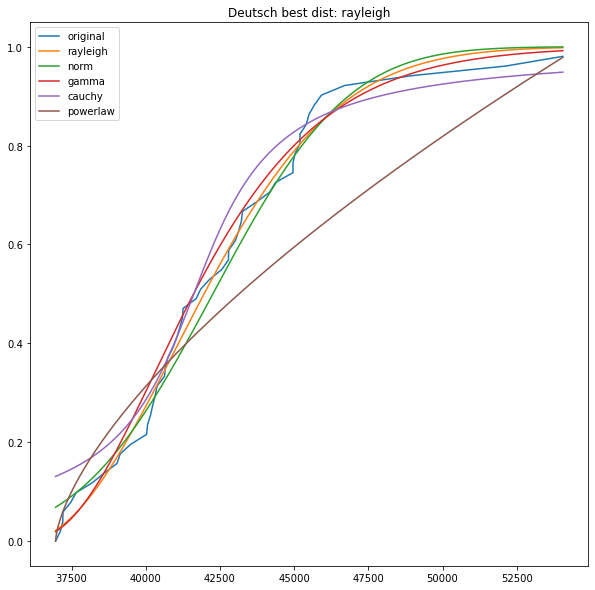

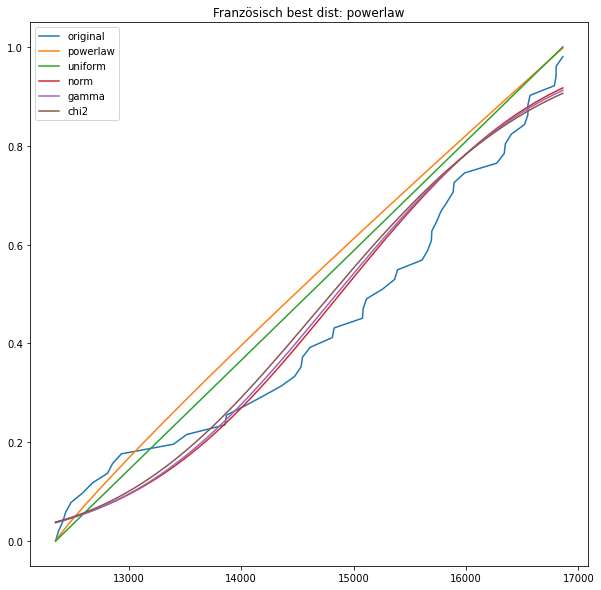

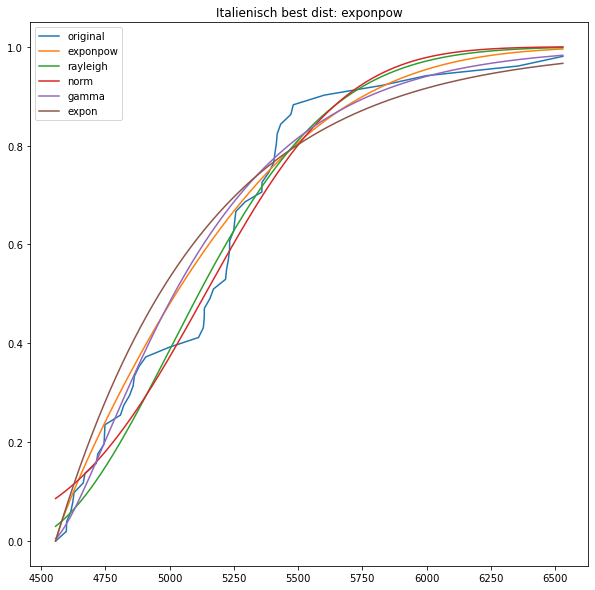

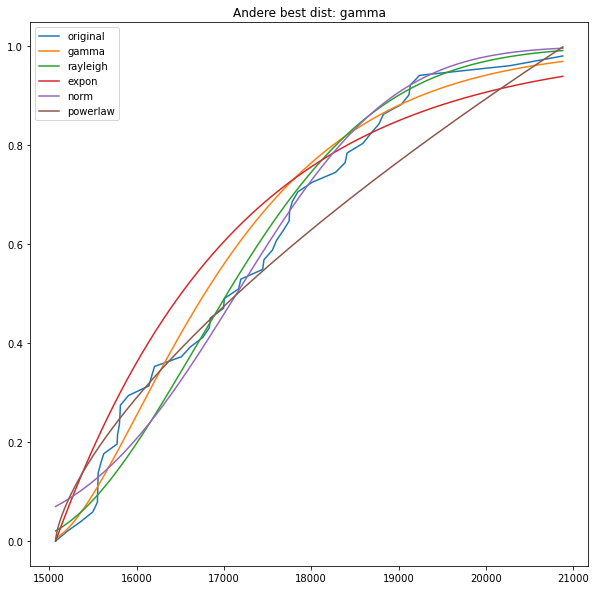

{'Deutsch': {'rayleigh': (35875.66260422994, 5170.619981728329)}, 'Französisch': {'powerlaw': (0.9193923801034853, 12347.954182363423, 4525.593834336862)}, 'Italienisch': {'exponpow': (0.8718519910689537, 4556.817426619439, 976.0623613871721)}, 'Andere': {'gamma': (1.908044062817634, 14966.236743144716, 1142.4315286795631)}}


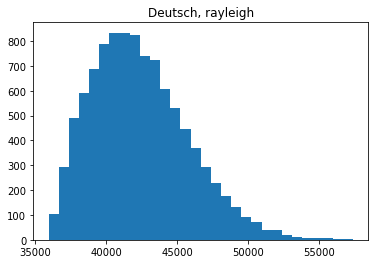

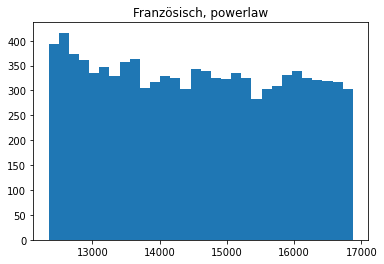

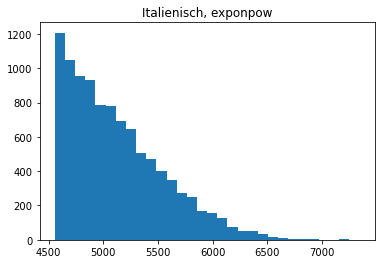

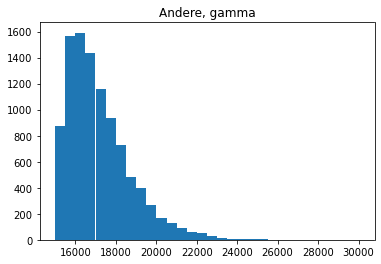

In [4]:
df_geburtenRate = get_geburtenrate_kanton()

""" df_hauptsprache_mean = get_hauptsprache_kanton("2010")

for year in range(2011, 2021):
    df_hs = get_hauptsprache_kanton(str(year))

    df_hauptsprache_mean = pd.concat((df_hauptsprache_mean, df_hs))

df_mean_hauptsprache = df_hauptsprache_mean.groupby(df_hauptsprache_mean.index).mean()

df_std_hauptsprache = df_hauptsprache_mean.groupby(df_hauptsprache_mean.index).std() / df_hauptsprache_mean.groupby(df_hauptsprache_mean.index).mean() #grosse varianz -> neuster Wert nehmen

df_mean_hauptsprache_percent = df_mean_hauptsprache.apply(lambda x: x / x.sum()) """

df_2020_hauptsprache = get_hauptsprache_kanton("2020")

df_2020_hauptsprache_percent = df_2020_hauptsprache.apply(lambda x: x / x.sum())

""" dict_birthRate_lang_distribution = {}
for year, row in df_geburtenRate.iterrows():
    dict_birthRate_languages = {}

    #iteriere über kantone
    for kanton, birthRate in row.iteritems():
        if kanton in df_mean_hauptsprache_percent.columns:
            #iteriere über sprachenanteil der kantone
            for sprache, langPercent in df_mean_hauptsprache_percent[kanton].iteritems():
                dict_birthRate_languages[sprache] = dict_birthRate_languages.get(sprache, 0) + birthRate * langPercent

    for key, value in list(dict_birthRate_languages.items()):
        item = dict_birthRate_lang_distribution.get(key, [])
        item.append(value)
        dict_birthRate_lang_distribution[key] = item """

dict_birthRate_lang_distribution = {}
for year, row in df_geburtenRate.iterrows():
    dict_birthRate_languages = {}

    #iteriere über kantone
    for kanton, birthRate in row.iteritems():
        if kanton in df_2020_hauptsprache_percent.columns:
            #iteriere über sprachenanteil der kantone
            for sprache, langPercent in df_2020_hauptsprache_percent[kanton].iteritems():
                dict_birthRate_languages[sprache] = dict_birthRate_languages.get(sprache, 0) + birthRate * langPercent

    for key, value in list(dict_birthRate_languages.items()):
        item = dict_birthRate_lang_distribution.get(key, [])
        item.append(value)
        dict_birthRate_lang_distribution[key] = item

dict_distributions = {}
for sprache, values in dict_birthRate_lang_distribution.items():
    f = fitter.Fitter(values, timeout=60,distributions=fitter.get_common_distributions())
    f.fit()

    method = "sumsquare_error"
    dict_distributions[sprache] = f.get_best(method=method)

    display_distributions_cdf(f, values, sprache, method)

for sprache, dist in dict_distributions.items():
    obj = getattr(stats, list(dist.keys())[0])
    params = dist[list(dist.keys())[0]]

    if type(params) is dict:
        params = list(params.values())

    dist_vals = obj.rvs(size=10000, *params)

    plt.hist(dist_vals, bins=30)
    plt.title(sprache + ", " + str(list(dist.keys())[0]))
    plt.show()

dill.dump(dict_distributions, open("distributions_nach_sprache.pick", mode='wb'))